## 1. Planning

- 문제 선정 : 게임 input을 색다르게 바꿔보자
  - ex) One hand clapping : 마이크 인식 → 노래 음정을 그림을 그려 퍼즐을 푸는
  - ex) Before your Eyes : 웹캠 → 눈의 깜박임을 통해 스토리를 진행하는
  - 이처럼 키보드와 마우스 input 이외에 다른 인풋을 넣어서 게임 플레이를 신선하게 느낄 수 있도록
  - 얼굴 표정 인식 : 웹캠으로 플레이어의 얼굴 표정을 인식하고, 표정에서 감정을 읽어내어 NPC가 다른 행동을 취하거나 플레이 경험이 달라진다
- 데이터 선정 : [FER 2013](https://www.kaggle.com/datasets/msambare/fer2013)
  - 데이터 특징
    - 다양한 사람들의, 다양한 각도의 얼굴 표정
    - 48*48 픽셀, grayscale
    - Angry, Disgused, Fearful, Happy, Sad, Surprised, Neutral
    - training set (28,709) + public test set (3,589)

  - 데이터 선정 이유
    - 

- 가설 수립  
  - 이유가 명확한가? (  )
  - 쓸모가 있는가?   (  )


- 모델 선정 
  - Transfer Learning : which Pre-Trained model? => MobileNet or ResNet50
  - 선택 이유 : 데이터셋? 해결 문제?
    - 실시간으로 웹캠을 통해서 얼굴 인식 및 감정 분류 수행해야
    - 성능 대비 사용 리소스가 적은 효율적인 모델
  - input shape : 224*224

Tasks
- CNN : 감정에 따른 얼굴 표정 분류
- Object Detection : 웹캠이 얼굴 인식 -> input으로 


# CNN - Classification

## 2. Preprocess

- 전처리 방식
- 데이터 형식 : 모델에 어떻게 입력?

In [ ]:
## google mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Pull Data

In [ ]:
import os, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import cv2

In [ ]:
##install kaggle module
! pip install -q kaggle

##copy kaggle API
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/access/kaggle.json ~/.kaggle/

##hide Kaggle API
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%capture
## download dataset
! kaggle datasets download -d ananthu017/emotion-detection-fer

## upzip
! unzip -qq emotion-detection-fer.zip

In [ ]:
!rm -rf emotion-detection-fer.zip

#### Dataset

##### Display Images

In [ ]:
PIC_SIZE = 48
TRAIN_DIR = '/content/train'
TEST_DIR = '/content/test'

In [ ]:
def display_img(emotion):
  plt.figure(figsize=(10,10))
  for i in range (1,10):
    plt.subplot(3,3,i)

    img_dir = TRAIN_DIR +'/'+ emotion+'/'
    img_path = os.listdir(img_dir)[i]
    img = load_img(os.path.join(img_dir, img_path), target_size = (PIC_SIZE, PIC_SIZE) )
    plt.imshow(img)
  plt.show()

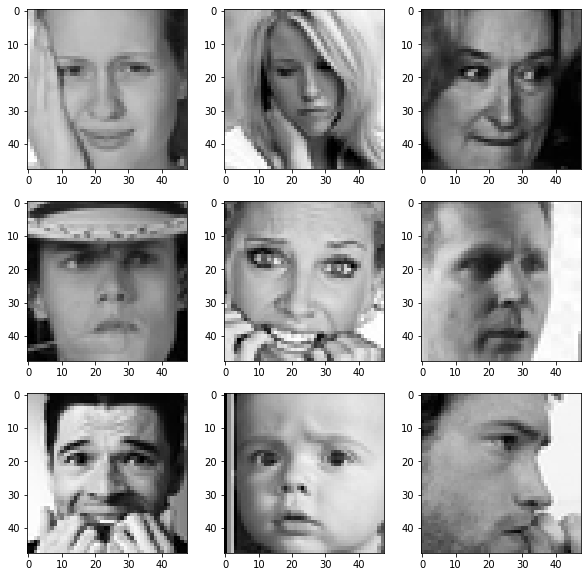

In [ ]:
display_img('fearful')

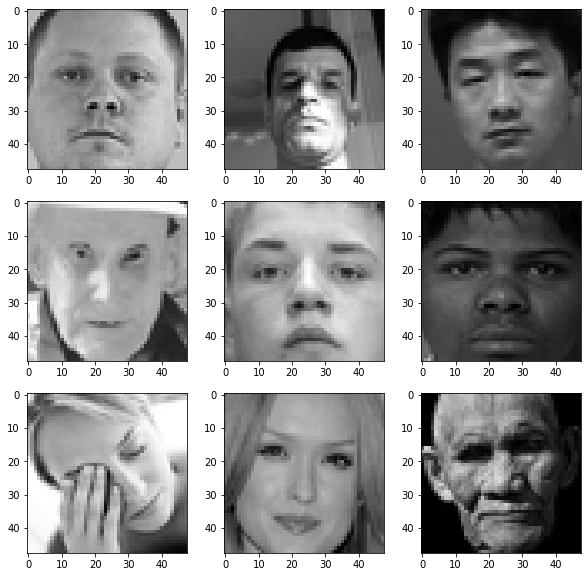

In [ ]:
display_img('neutral')

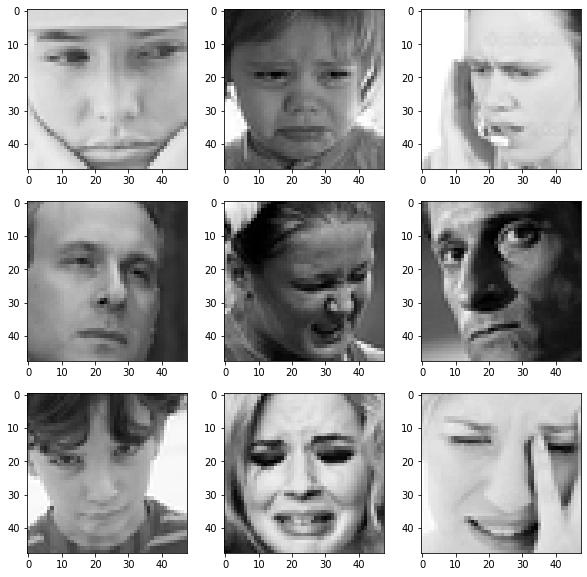

In [ ]:
display_img('sad')

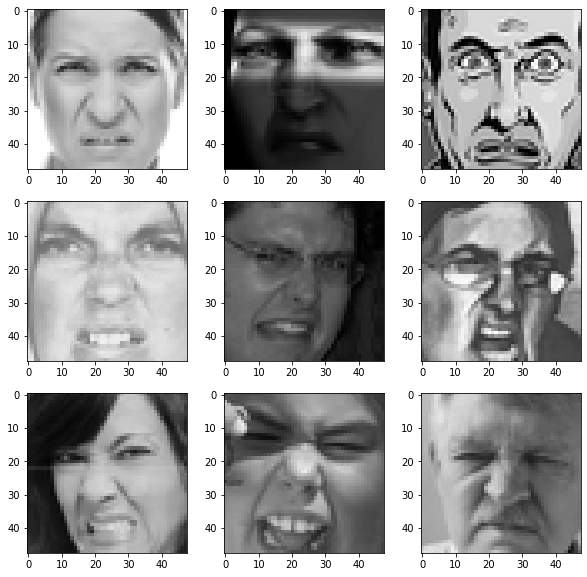

In [ ]:
display_img('disgusted')

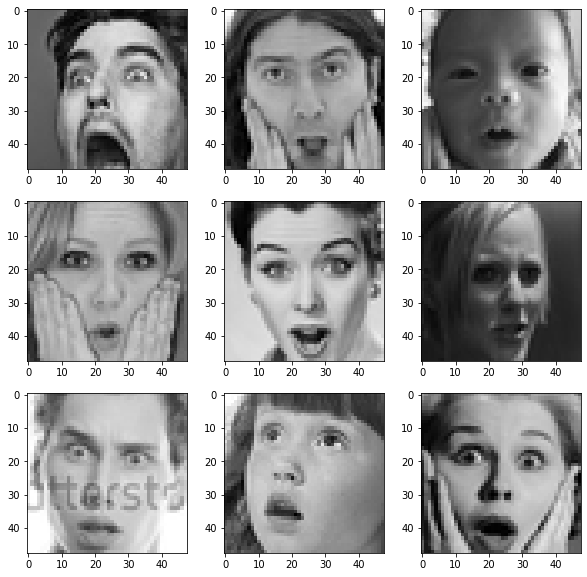

In [ ]:
display_img('surprised')

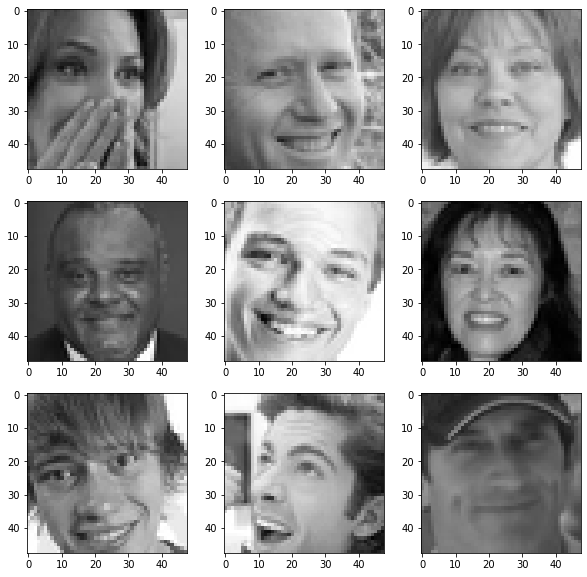

In [ ]:
display_img('happy')

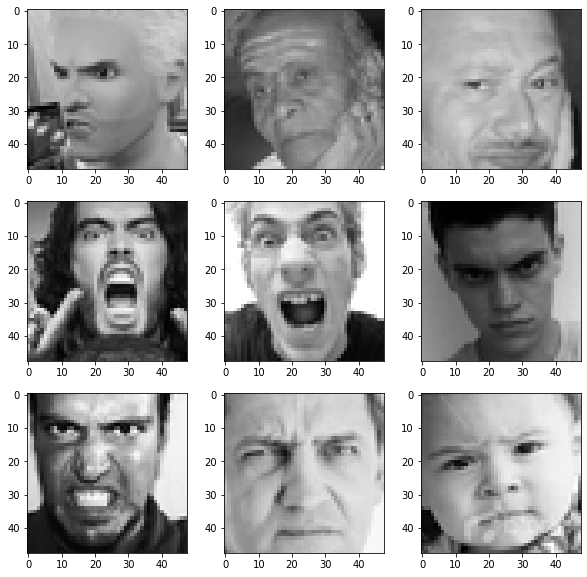

In [ ]:
display_img('angry')

##### Distribution

In [ ]:
LS_LABEL = os.listdir(TRAIN_DIR)
print(LS_LABEL)

['disgusted', 'neutral', 'angry', 'fearful', 'sad', 'happy', 'surprised']


In [ ]:
## func : count of images in directory
def dir_len(file_dir):
  ls_count = []
  for i in range(len(LS_LABEL)):
    path = os.path.join(file_dir, LS_LABEL[i])
    ls_count.append(len(os.listdir(path)))
  return ls_count

In [ ]:
## df : distribution of dataset
df_dis = pd.DataFrame([dir_len(TRAIN_DIR), dir_len(TEST_DIR)],
                      columns = LS_LABEL,
                      index = ['train', 'test'])
df_dis['SUM'] = [sum(dir_len(TRAIN_DIR)), sum(dir_len(TEST_DIR))]
df_dis

,disgusted,neutral,angry,fearful,sad,happy,surprised,SUM
train,436,4965,3995,4097,4830,7215,3171,28709
test,111,1233,958,1024,1247,1774,831,7178


disgusted : 다른 카테고리에 비해 너무 데이터 셋이 너무 적다
- Solution : Data augmentation (이미지 증강)

#### Data Cleaning
- upsample to 244*244 (for MobileNet) (O)
- Data augmentation : catagory 'disgusted' (X)
- shuffle, labeling (O)
- normalizing (X)

##### upsampling : bi-linear interpolation

In [ ]:
IMG_SIZE = 224 #for ImageNet : 224*224

In [ ]:
## data arrays
train_data = []
test_data = []

## func : 
def convertData(data_array, data_dir):
  ##get catagory
  for category in LS_LABEL:
    path = os.path.join(data_dir, category) # for every label folder
    catagory_num = LS_LABEL.index(category) # number = label
    ## get image 
    for img in os.listdir(path):
      img_arr = cv2.imread(os.path.join(path, img)) # for every image
      resize_arr = cv2.resize(img_arr, (IMG_SIZE,IMG_SIZE)) # resize
      data_array.append([resize_arr, catagory_num]) # append to array with label

In [ ]:
convertData(train_data, TRAIN_DIR)
convertData(test_data, TEST_DIR)

In [ ]:
print(len(train_data))
print(len(test_data))

28709
7178


##### shuffle, label, normalize

In [ ]:
random.shuffle(train_data)
random.shuffle(test_data)

In [ ]:
np.array(train_data, dtype=object).shape

(28709, 2)

In [ ]:
X=[] ## feature
y=[] ## label

for features, label in train_data:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3) ## convert to 4dim (for MobileNet)
X.shape

(28709, 224, 224, 3)

In [ ]:
# ## for system RAM : reduce overload
# train_data = None
# test_data = None

In [ ]:
X[0].shape

(224, 224, 3)

In [ ]:
Y=np.array(y)
Y.shape

(28709,)

In [ ]:
X_test=[] ## feature
y_test=[] ## label

for features, label in test_data:
  X_test.append(features)
  y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3) ## convert to 4dim (for MobileNet)
Y_test=np.array(y_test)

X_test.shape, Y_test.shape

((7178, 224, 224, 3), (7178,))

## 3. Model

### Transfer Learning

#### Pre-trained Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV3Large,ResNet50,InceptionV3

In [ ]:
def modelTuning(model, pretrained_model):
  # model = Sequential()
  model.add(pretrained_model)
  # model.add(GlobalAveragePooling2D())
  model.add(Dense(256,activation='relu'))
  model.add(Dense(128,activation='relu'))
  model.add(Dense(7,activation='softmax'))
  return model

In [ ]:
def compile_fit(model):
  model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
  model_hist = model.fit(X, Y,
                          batch_size=256,
                          validation_data=(X_test, Y_test),
                          epochs=15)
  return model, model_hist

##### MobileNetV3Large

In [ ]:
preMod_MNv3 = tf.keras.applications.MobileNetV3Large(input_shape = (IMG_SIZE, IMG_SIZE,3)
                                                          ,include_top=False) ## Pre-trained Model
preMod_MNv3.trainable = False                                                     

12697600/12683000 [==============================] - 0s 0us/step


In [ ]:
preMod_MNv3.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [ ]:
model_MNv3 = Sequential()
modelTuning(model_MNv3, preMod_MNv3)
model_MNv3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               246016    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 7)                 903       
                                                                 
Total params: 3,276,167
Trainable params: 279,815
Non-

In [ ]:
model,hist = compile_fit(model_MNv3) #256,128

Epoch 1/15
113/113 [==============================] - 26s 199ms/step - loss: 1.4500 - accuracy: 0.4464 - val_loss: 1.3560 - val_accuracy: 0.4908
Epoch 2/15
113/113 [==============================] - 21s 184ms/step - loss: 1.2455 - accuracy: 0.5331 - val_loss: 1.2640 - val_accuracy: 0.5224
Epoch 3/15
113/113 [==============================] - 21s 183ms/step - loss: 1.1552 - accuracy: 0.5683 - val_loss: 1.2376 - val_accuracy: 0.5311
Epoch 4/15
113/113 [==============================] - 21s 184ms/step - loss: 1.0837 - accuracy: 0.5981 - val_loss: 1.2112 - val_accuracy: 0.5442
Epoch 5/15
113/113 [==============================] - 21s 184ms/step - loss: 1.0119 - accuracy: 0.6290 - val_loss: 1.2207 - val_accuracy: 0.5486
Epoch 6/15
113/113 [==============================] - 21s 184ms/step - loss: 0.9432 - accuracy: 0.6562 - val_loss: 1.2103 - val_accuracy: 0.5566
Epoch 7/15
113/113 [==============================] - 21s 184ms/step - loss: 0.8709 - accuracy: 0.6868 - val_loss: 1.2493 - val_ac

##### ResNet50

In [ ]:
RN50 = ResNet50(input_shape = (IMG_SIZE, IMG_SIZE,3),include_top = False, pooling='max')
RN50.trainable = False
RN50.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
model_RN50 = Sequential()
modelTuning(model_RN50, RN50)
model_RN50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 7)                 903       
                                                                 
Total params: 24,146,055
Trainable params: 558,343
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
compile_fit(model_RN50)

Epoch 1/15
113/113 [==============================] - 54s 446ms/step - loss: 2.2779 - accuracy: 0.3502 - val_loss: 1.5780 - val_accuracy: 0.4322
Epoch 2/15
113/113 [==============================] - 48s 429ms/step - loss: 1.4245 - accuracy: 0.4689 - val_loss: 1.4432 - val_accuracy: 0.4652
Epoch 3/15
113/113 [==============================] - 48s 429ms/step - loss: 1.2989 - accuracy: 0.5103 - val_loss: 1.3655 - val_accuracy: 0.4907
Epoch 4/15
113/113 [==============================] - 48s 429ms/step - loss: 1.2258 - accuracy: 0.5394 - val_loss: 1.3184 - val_accuracy: 0.5104
Epoch 5/15
113/113 [==============================] - 48s 430ms/step - loss: 1.1847 - accuracy: 0.5574 - val_loss: 1.3559 - val_accuracy: 0.4836
Epoch 6/15
113/113 [==============================] - 49s 430ms/step - loss: 1.1497 - accuracy: 0.5704 - val_loss: 1.3046 - val_accuracy: 0.5160
Epoch 7/15
113/113 [==============================] - 48s 430ms/step - loss: 1.0970 - accuracy: 0.5889 - val_loss: 1.3506 - val_ac

(<keras.engine.sequential.Sequential at 0x7f77f92c25d0>,
 <keras.callbacks.History at 0x7f74ee5ca6d0>)

##### InceptionV3

In [ ]:
IV3 = InceptionV3(input_shape = (IMG_SIZE, IMG_SIZE,3),include_top = False)
IV3.trainable = False
IV3.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
model_IV3 = Sequential()
modelTuning(model_IV3, IV3)
model_IV3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 7)                 903       
                                                                 
Total params: 22,361,127
Trainable params: 558,343
Non-trainable params: 21,802,784
______________________________________

In [ ]:
compile_fit(model_IV3)

Epoch 1/15
113/113 [==============================] - 51s 327ms/step - loss: 5.9546 - accuracy: 0.2202 - val_loss: 2.2794 - val_accuracy: 0.2310
Epoch 2/15
113/113 [==============================] - 34s 303ms/step - loss: 2.0370 - accuracy: 0.2612 - val_loss: 2.5577 - val_accuracy: 0.1630
Epoch 3/15
113/113 [==============================] - 34s 304ms/step - loss: 1.9310 - accuracy: 0.2769 - val_loss: 2.4197 - val_accuracy: 0.1498
Epoch 4/15
113/113 [==============================] - 34s 305ms/step - loss: 1.8505 - accuracy: 0.2881 - val_loss: 1.7934 - val_accuracy: 0.3080
Epoch 5/15
113/113 [==============================] - 34s 304ms/step - loss: 1.7474 - accuracy: 0.3163 - val_loss: 1.7773 - val_accuracy: 0.3252
Epoch 6/15
113/113 [==============================] - 34s 303ms/step - loss: 1.7485 - accuracy: 0.3222 - val_loss: 1.7834 - val_accuracy: 0.3125
Epoch 7/15
113/113 [==============================] - 34s 303ms/step - loss: 1.7233 - accuracy: 0.3267 - val_loss: 2.1556 - val_ac

(<keras.engine.sequential.Sequential at 0x7f789220fb10>,
 <keras.callbacks.History at 0x7f788f688dd0>)

## 4. Performance

- 성능
- 일반화 : 교차검증
  - 최적화 : 하이퍼파리미터 변경
- 한계점과 추후 해결 방안

### Hyperparameter Tuning

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import BatchNormalization
from sklearn.model_selection import  GridSearchCV

In [ ]:
def create_model(self, nodes,activation):
  model = Sequential()
  model.add(nodes, preMod_MNv3)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(nodes,activation=activation))
  model.add(Dense(nodes/2,activation=activation))
  model.add(Dense(7,activation='softmax'))

  model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
  return model

## KerasClassifier : wrapping
model = KerasClassifier(build_fn=create_model, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  from ipykernel import kernelapp as app


In [ ]:
# search area
batch_size = [64, 128, 256, 512]
epochs = [10, 15, 20, 25, 30]
nodes = [64, 128, 256]
activation = ['relu', 'sigmoid']

param_grid = dict(batch_size=batch_size
                  , epochs=epochs
                  , nodes=nodes
                  , activation=activation
                  )

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [ ]:
# 최적의 결과값을 낸 파라미터를 출력합니다
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print(f"Means: {mean}, Stdev: {stdev} with: {param}")

### Chance Level comparision

### Validation

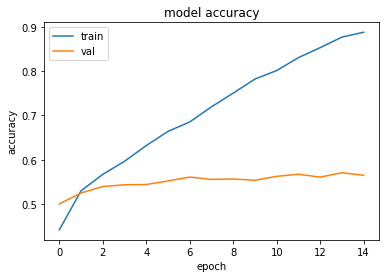

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save Model

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model') 

In [ ]:
## download as zip file
!zip -r /content/saved_model.zip /content/saved_model
from google.colab import files
files.download("/saved_model.zip")

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 91%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/keras_metadata.pb (deflated 95%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_model/variables/variables.index (deflated 73%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pwd

/content


### Load Model

In [ ]:
!mkdir -p loaded_model

In [ ]:
#unzip file
!mkdir -p loaded_model
!unzip /content/saved_model.zip -d /content/loaded_model/

Archive:  /content/saved_model.zip
replace /content/loaded_model/keras_metadata.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/loaded_model/keras_metadata.pb  
replace /content/loaded_model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/loaded_model/saved_model.pb  
replace /content/loaded_model/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/loaded_model/variables/variables.data-00000-of-00001  
replace /content/loaded_model/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/loaded_model/variables/variables.index  


In [ ]:
## load saved model
import tensorflow as tf
model = tf.keras.models.load_model('/content/loaded_model/')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 7)                 903       
                                                                 
Total params: 3,276,167
Trainable params: 279,815
Non-tr

# Face Detection

### import module

Reference : [face detector xml file](https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml)

### test image

#### import test image

In [ ]:
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

(642, 945, 3)


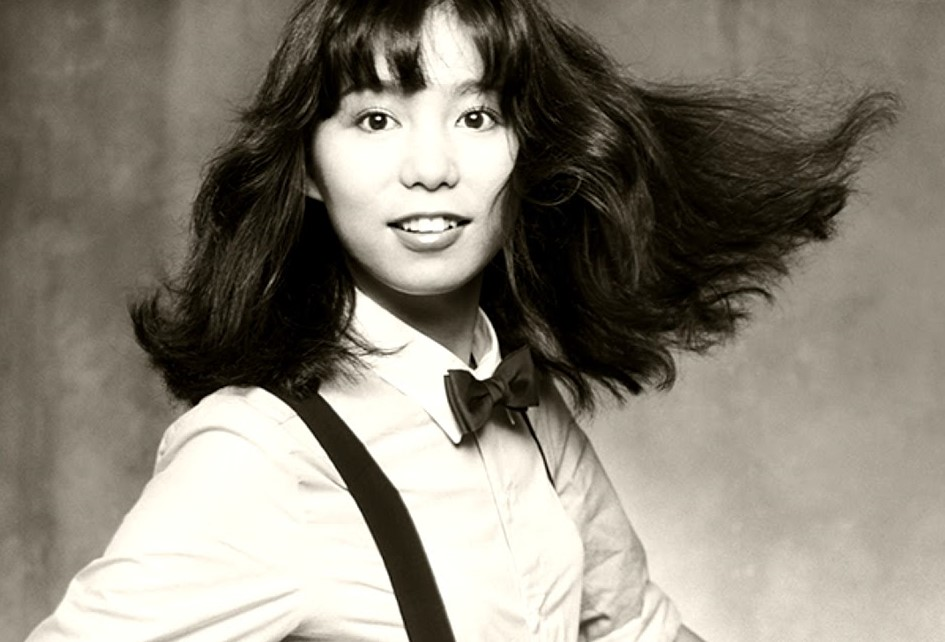

In [ ]:
## test image
img_test = cv2.imread('/content/drive/MyDrive/data/image/img_plasticLove.jpg')
print(img_test.shape)

from google.colab.patches import cv2_imshow
cv2_imshow(img_test)

(642, 945)


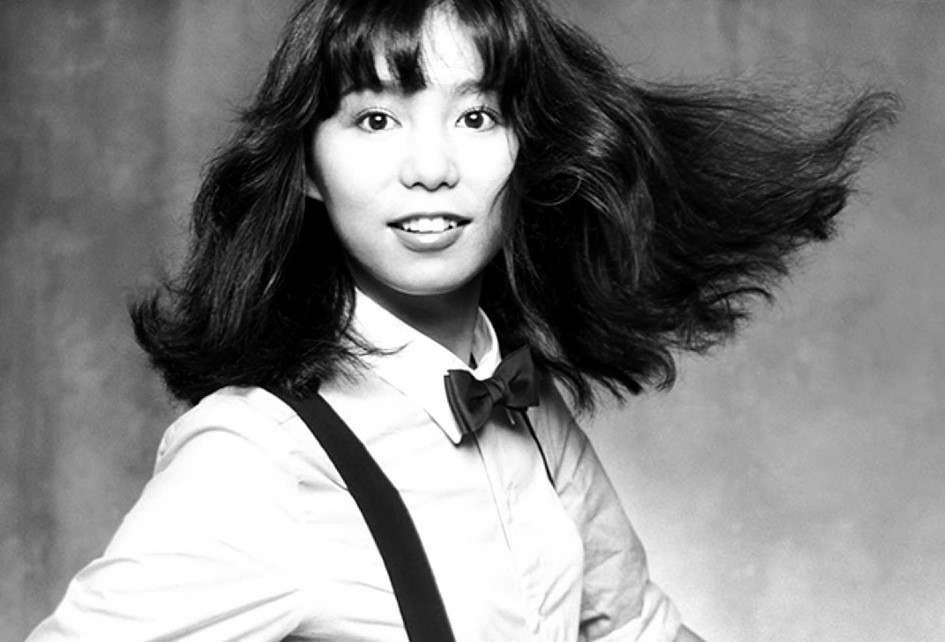

In [ ]:
img_testGray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY) # BGR -> GRAY
print(img_testGray.shape)
cv2_imshow(img_testGray)

#### detect face

In [ ]:
faces = face_classifier.detectMultiScale(img_test,1.1,4)
for x,y,w,h in faces:
  box_gray = img_testGray[y:y+h, x:x+w]
  box_color = img_test[y:y+h, x:x+w]
  cv2.rectangle(img_test, (x,y), (x+w,y+h),(255,0,0),2)
  facess = face_classifier.detectMultiScale(box_color)
  if len(facess) == 0:
    print("Face not detected")
  else:
    for (ex,ey,ew,eh) in facess:
      face_box = box_color[ey:ey+eh, ex:ex+ew]

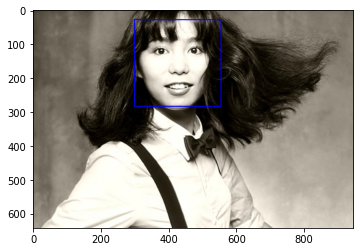

In [ ]:
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))

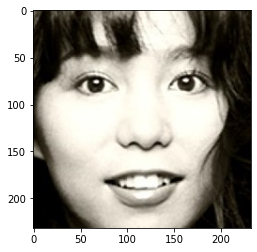

In [ ]:
plt.imshow(cv2.cvtColor(face_box, cv2.COLOR_BGR2RGB))

In [ ]:
img_test_final = cv2.resize(face_box, (224,224))
img_test_final = np.expand_dims(img_test_final, axis=0) ## need additional 4th dim
# img_test_final = img_test_final/255.0 ##normalizing

#### predict with model

In [ ]:
test_pred = model.predict(img_test_final)

In [ ]:
test_pred[0].astype('float32') #prediction result : probablity

array([6.3621916e-04, 1.6202848e-02, 1.0327909e-03, 5.2850610e-03,
       7.9174942e-01, 1.8489616e-01, 1.9755478e-04], dtype=float32)

In [ ]:
LS_LABEL = ['fearful', 'sad', 'disgusted', 'happy', 'surprised', 'neutral', 'angry']

In [ ]:
LS_LABEL[np.argmax(test_pred)] #classified as?

'surprised'

## Realtime video demo

### Connect local webcam -> colab

### video demo

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


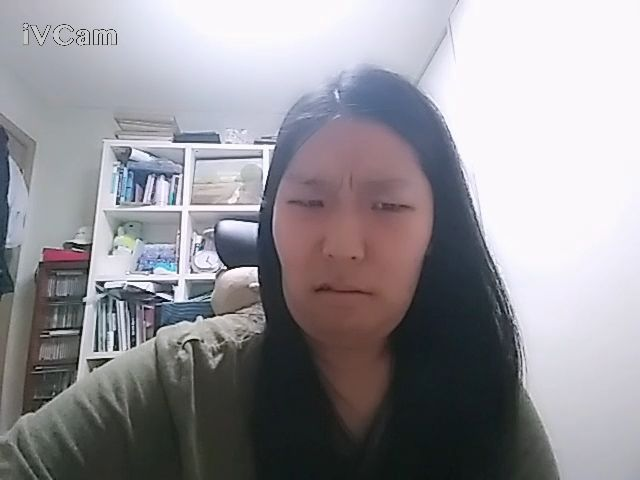

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
classifier = model #after load model
img_test = cv2.imread('photo.jpg')
img_testGray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY) # BGR -> GRAY

In [ ]:
faces = face_classifier.detectMultiScale(img_test,1.1,4)
for x,y,w,h in faces:
  box_gray = img_testGray[y:y+h, x:x+w]
  box_color = img_test[y:y+h, x:x+w]
  cv2.rectangle(img_test, (x,y), (x+w,y+h),(255,0,0),2)
  facess = face_classifier.detectMultiScale(box_color)
  if len(facess) == 0:
    print("Face not detected")
  else:
    for (ex,ey,ew,eh) in facess:
      face_box = box_color[ey:ey+eh, ex:ex+ew]

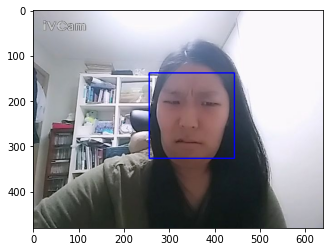

In [ ]:
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))

In [ ]:
img_test_final = cv2.resize(face_box, (224,224))
img_test_final = np.expand_dims(img_test_final, axis=0) ## need additional 4th dim

In [ ]:
test_pred = model.predict(img_test_final)

In [ ]:
test_pred[0].astype('float32') #prediction result : probablity
##['fearful', 'sad', 'disgusted', 'happy', 'surprised', 'neutral', 'angry']

array([5.6595315e-04, 9.9729425e-01, 4.3574128e-05, 7.0903619e-04,
       1.3990278e-05, 1.3716503e-03, 1.6367894e-06], dtype=float32)

In [ ]:
test_pred

array([[5.6595315e-04, 9.9729425e-01, 4.3574128e-05, 7.0903619e-04,
        1.3990278e-05, 1.3716503e-03, 1.6367894e-06]], dtype=float32)

In [ ]:
LS_LABEL[np.argmax(test_pred)] #classified as? 

'sad'

<BarContainer object of 7 artists>

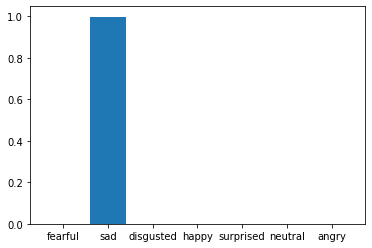

In [ ]:
plt.bar(LS_LABEL,test_pred[0])